## Tutorial: CommonRoad Lanelet-based Curvilinear Coordinatesystem

This tutorial shows you how to create a curvilinear coordinate system from lanelets using CommonRoad scenarios. We start with opening a CommonRoad XML file.

### Step 1: Read a CommonRoad scenario

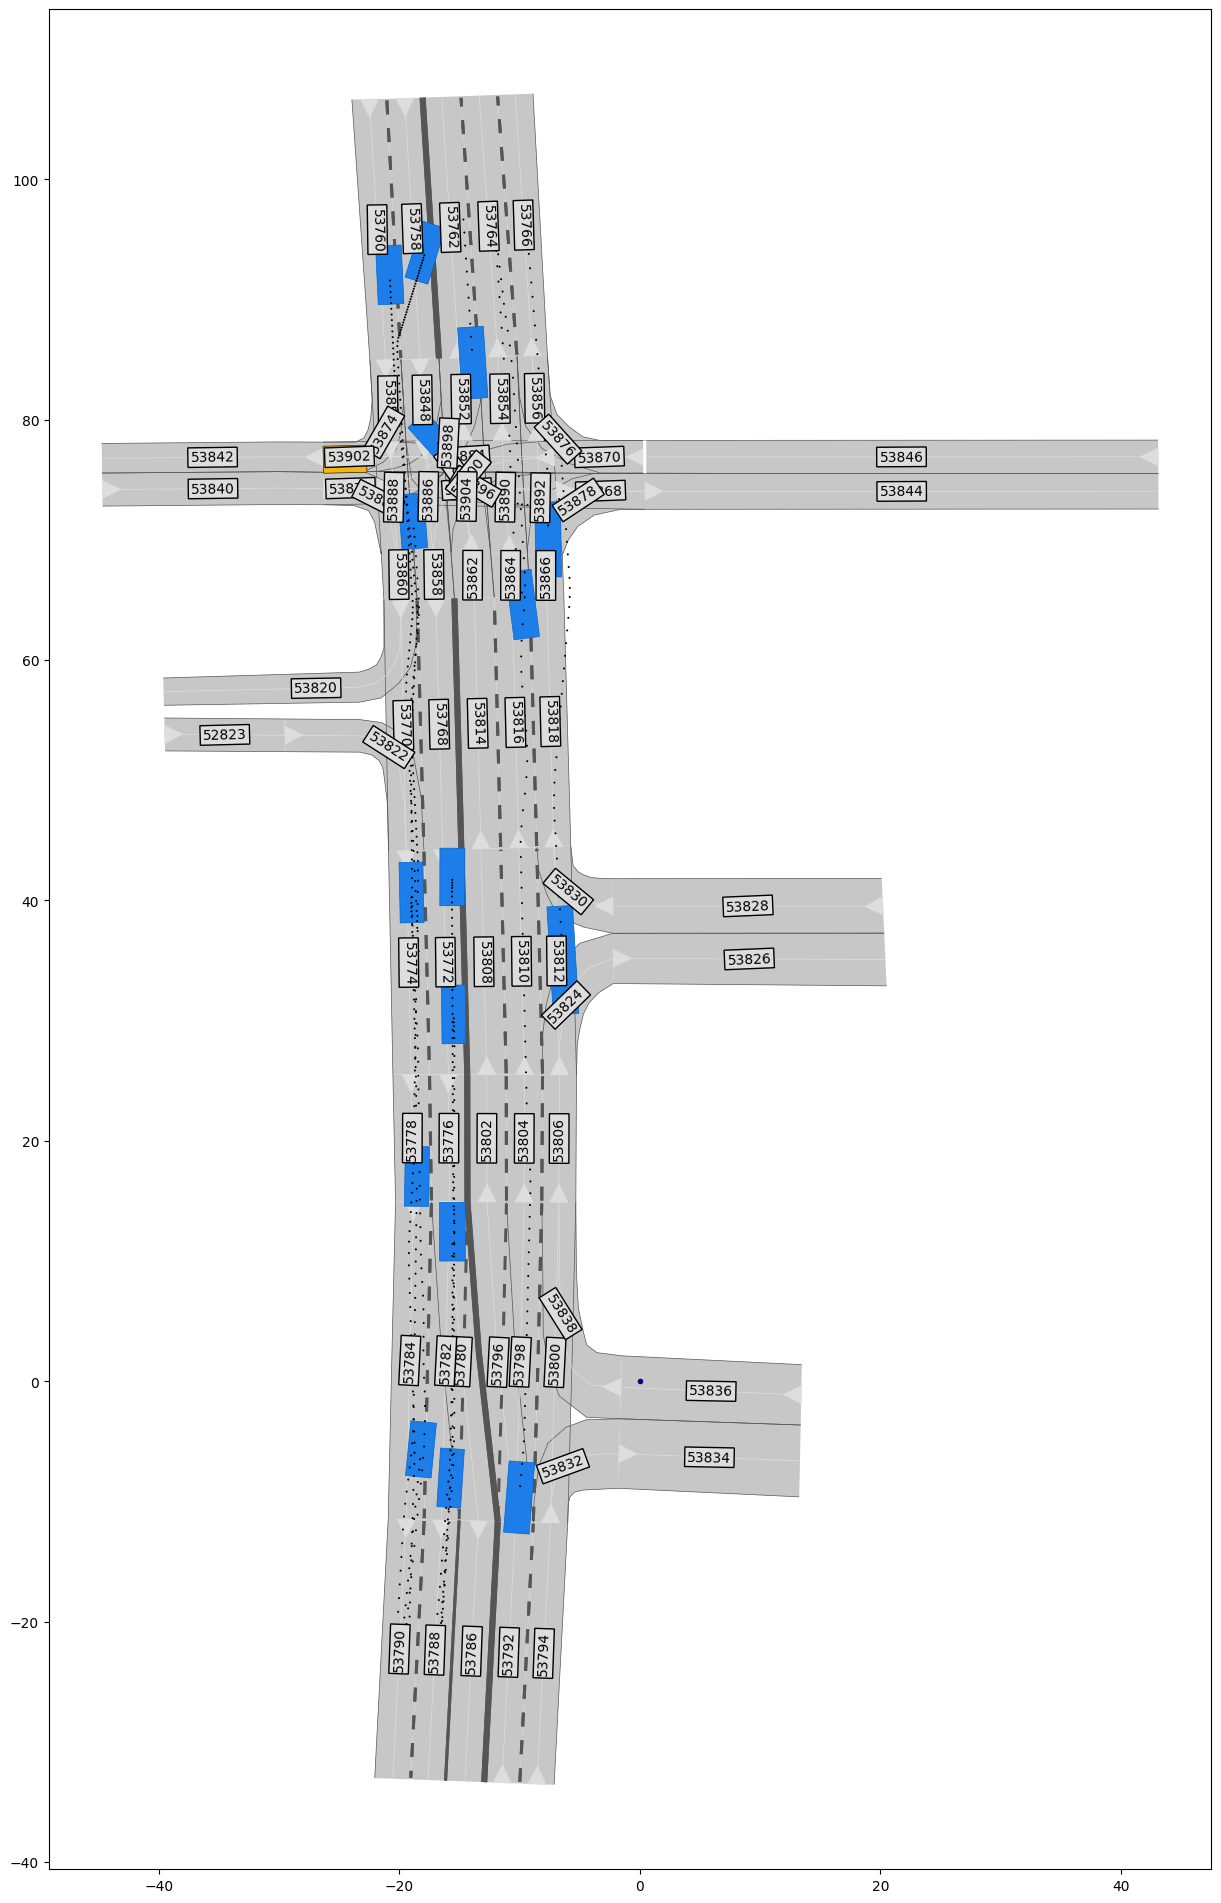

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.visualization.draw_dispatch_cr import draw_object

# load the CommonRoad scenario, note that you might have to modify the path to the CommonRoad scenario!
file_path = os.path.join(os.getcwd(), '../example_scenarios/USA_Peach-2_1_T-1.xml')

scenario, planning_problem_set = CommonRoadFileReader(file_path).open()

# plot the scenario in the initial time step
plt.figure(figsize=(15, 30), dpi=100)
draw_object(scenario, draw_params={'time_begin': 0, 'scenario': {'lanelet_network': {
                        'lanelet': {'show_label': True}}}})
draw_object(planning_problem_set)
plt.gca().set_aspect('equal')
plt.show()

### Step 2: Create the coordinate system

We will merge the lanelets 53792-53796-53802-53808-53814-53862-53894-53902-53842 and use this new lanelet as coordinate system.

In [2]:
from commonroad.scenario.lanelet import Lanelet
from commonroad_dc.lanelet_ccosy.lanelet_ccosy import LaneletCoordinateSystem

starting_lanelet_id = 53792
lanelet_ids_to_merge = [53796 ,53802 ,53808 ,53814 ,53862 ,53894 ,53902 ,53842]
lanelet_network = scenario.lanelet_network

lanelet = lanelet_network.find_lanelet_by_id(starting_lanelet_id)
for lanelet_id_to_merge in lanelet_ids_to_merge:
    lanelet_to_merge = lanelet_network.find_lanelet_by_id(lanelet_id_to_merge)
    lanelet = Lanelet.merge_lanelets(lanelet, lanelet_to_merge)
lanelet_ccosy = LaneletCoordinateSystem(lanelet)

### Step 3: Visualize the coordinate system

We can visualize the segments of the coordinate system with the commonroad_ccosy.visualization module. 

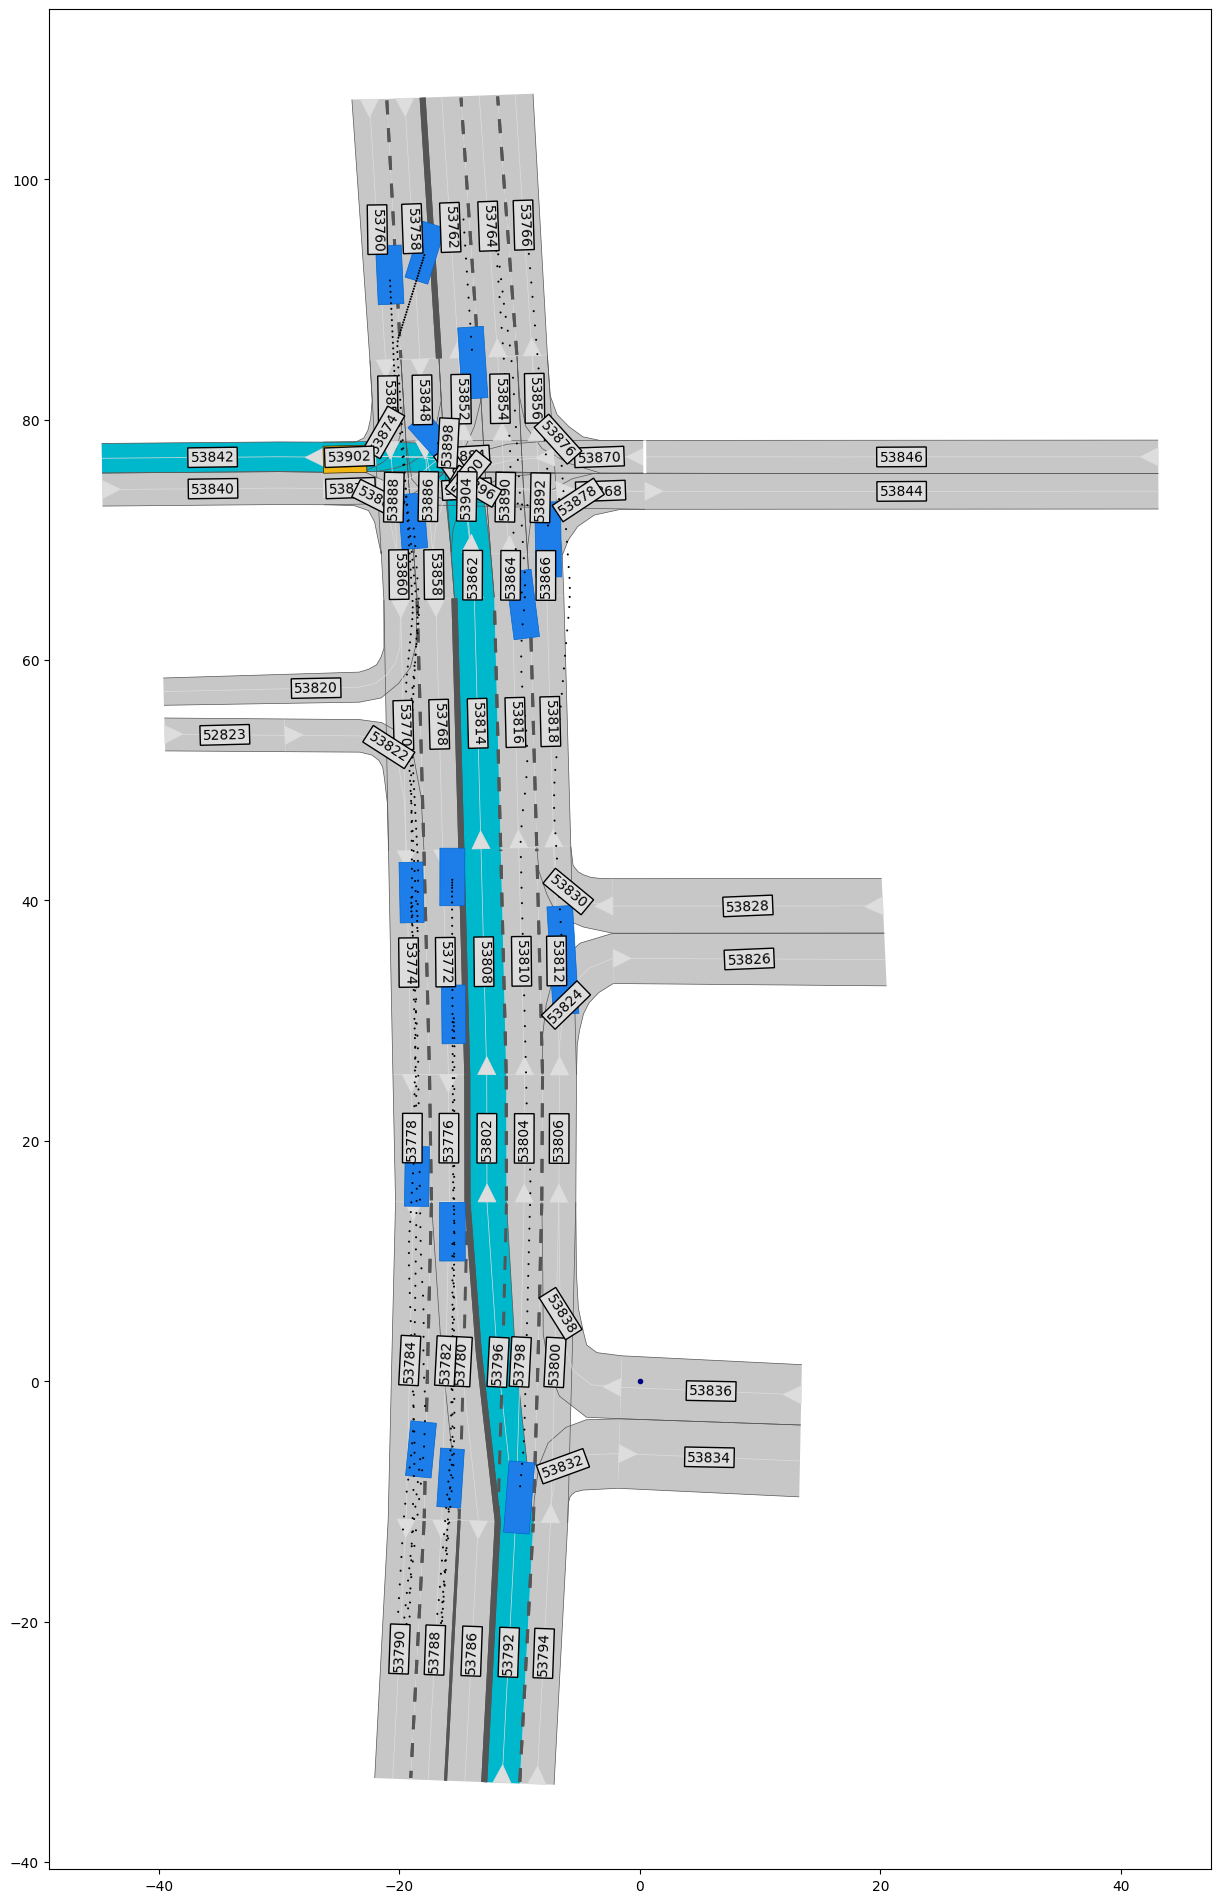

In [3]:
# Plot the scenario
plt.figure(figsize=(15, 30), dpi=100)
draw_object(scenario, draw_params={'time_begin': 0, 'scenario': {'lanelet_network': {
                        'lanelet': {'show_label': True}}}})

# Plot the ccosy
draw_object(lanelet_ccosy.lanelet, draw_params={'lanelet': {
                # 'left_bound_color': '#0de309',
                # 'right_bound_color': '#0de309',
                # 'center_bound_color': '#0de309',
                'unique_colors': False,  
                'draw_stop_line': False,
                'stop_line_color': '#ffffff',
                'draw_line_markings': False,
                'draw_left_bound': False,
                'draw_right_bound': False,
                'draw_center_bound': False,
                'draw_border_vertices': False,
                'draw_start_and_direction': False,
                'show_label': False,
                'draw_linewidth': 0.5,
                'fill_lanelet': True,
                'facecolor': '#00b8cc'
            }})
draw_object(planning_problem_set)
plt.gca().set_aspect('equal')
plt.show()

### Step 4: Project position to the lanelet

Now, we can convert coordinates from the Cartesian frame to the lanelet-based curvilinear coordinate system and backwards.

In [4]:
import numpy as np

def project_and_plot(lanelet_ccosy, position):
    print(f"Orginal position: {position}")
    
    p_curvilinear, relative_position = lanelet_ccosy.get_extrapolated_curvi_coords(position)
    print(f"Converted curvilinear position: {p_curvilinear}, relative position: {relative_position}")
    
    p_cartesian = lanelet_ccosy.get_extrapolated_cartesian_coords(p_curvilinear)
    print(f"Backconverted cartesian position: {p_cartesian}")
    
    lanelet_point, relative_position = lanelet_ccosy.get_extrapolated_cartesian_coords(np.array([p_curvilinear[0], 0]))
    print(f"Projected point on the lanelet: {lanelet_point}, relative position: {relative_position}")

    
    # Plot the scenario
    plt.figure(figsize=(15, 30), dpi=100)
    draw_object(scenario, draw_params={'time_begin': 0, 'scenario': {
        'lanelet_network': {'lanelet': {'show_label': False,}}},
        'dynamic_obstacle':{
            'trajectory':{'draw_trajectory':False}}
                                       })
    
    # Plot the ccosy
    draw_object(lanelet_ccosy.lanelet, draw_params={'lanelet': {
                    'unique_colors': False,  
                    'draw_stop_line': False,
                    'stop_line_color': '#ffffff',
                    'draw_line_markings': False,
                    'draw_left_bound': False,
                    'draw_right_bound': False,
                    'draw_center_bound': False,
                    'draw_border_vertices': False,
                    'draw_start_and_direction': False,
                    'show_label': False,
                    'draw_linewidth': 0.5,
                    'fill_lanelet': True,
                    'facecolor': '#00b8cc'
                }})
    draw_object(planning_problem_set)
    plt.plot([position[0], lanelet_point[0]], [position[1], lanelet_point[1]], zorder=100, linewidth=2, marker='o', color='red')
    proj_domain_border = np.asarray(lanelet_ccosy.projection_domain())
    plt.plot(proj_domain_border[:, 0], proj_domain_border[:, 1], zorder=100, color='orange')
    
    plt.scatter(lanelet_ccosy.bounding_points[:, 0], lanelet_ccosy.bounding_points[:, 1], color='orange')
    
    
    cv = lanelet_ccosy.lanelet.center_vertices
    plt.plot(cv[:, 0], cv[:, 1], zorder=100, marker='o', color='green')
    

    #plt.scatter([proj_domain_border[int(proj_domain_border.shape[0]/2)-1,0],],[proj_domain_border[int(proj_domain_border.shape[0]/2)-1,1],],zorder=100,marker='o', color='blue') 
    
    
    
    plt.gca().set_aspect('equal')
    plt.show()



green: lanelet centerline (reference path) <br>
orange: projection domain border <br>
red: cartesian position and curvilinear projection

Orginal position: [0 0]
Converted curvilinear position: [ 32.3190381  -11.53136995], relative position: LongitudinalRelativePointPosition.InDomain
Backconverted cartesian position: (array([-2.87858626e-11,  2.90309332e-10]), <LongitudinalRelativePointPosition.InDomain: 0>)
Projected point on the lanelet: [-11.4750925  -1.1378686], relative position: LongitudinalRelativePointPosition.InDomain


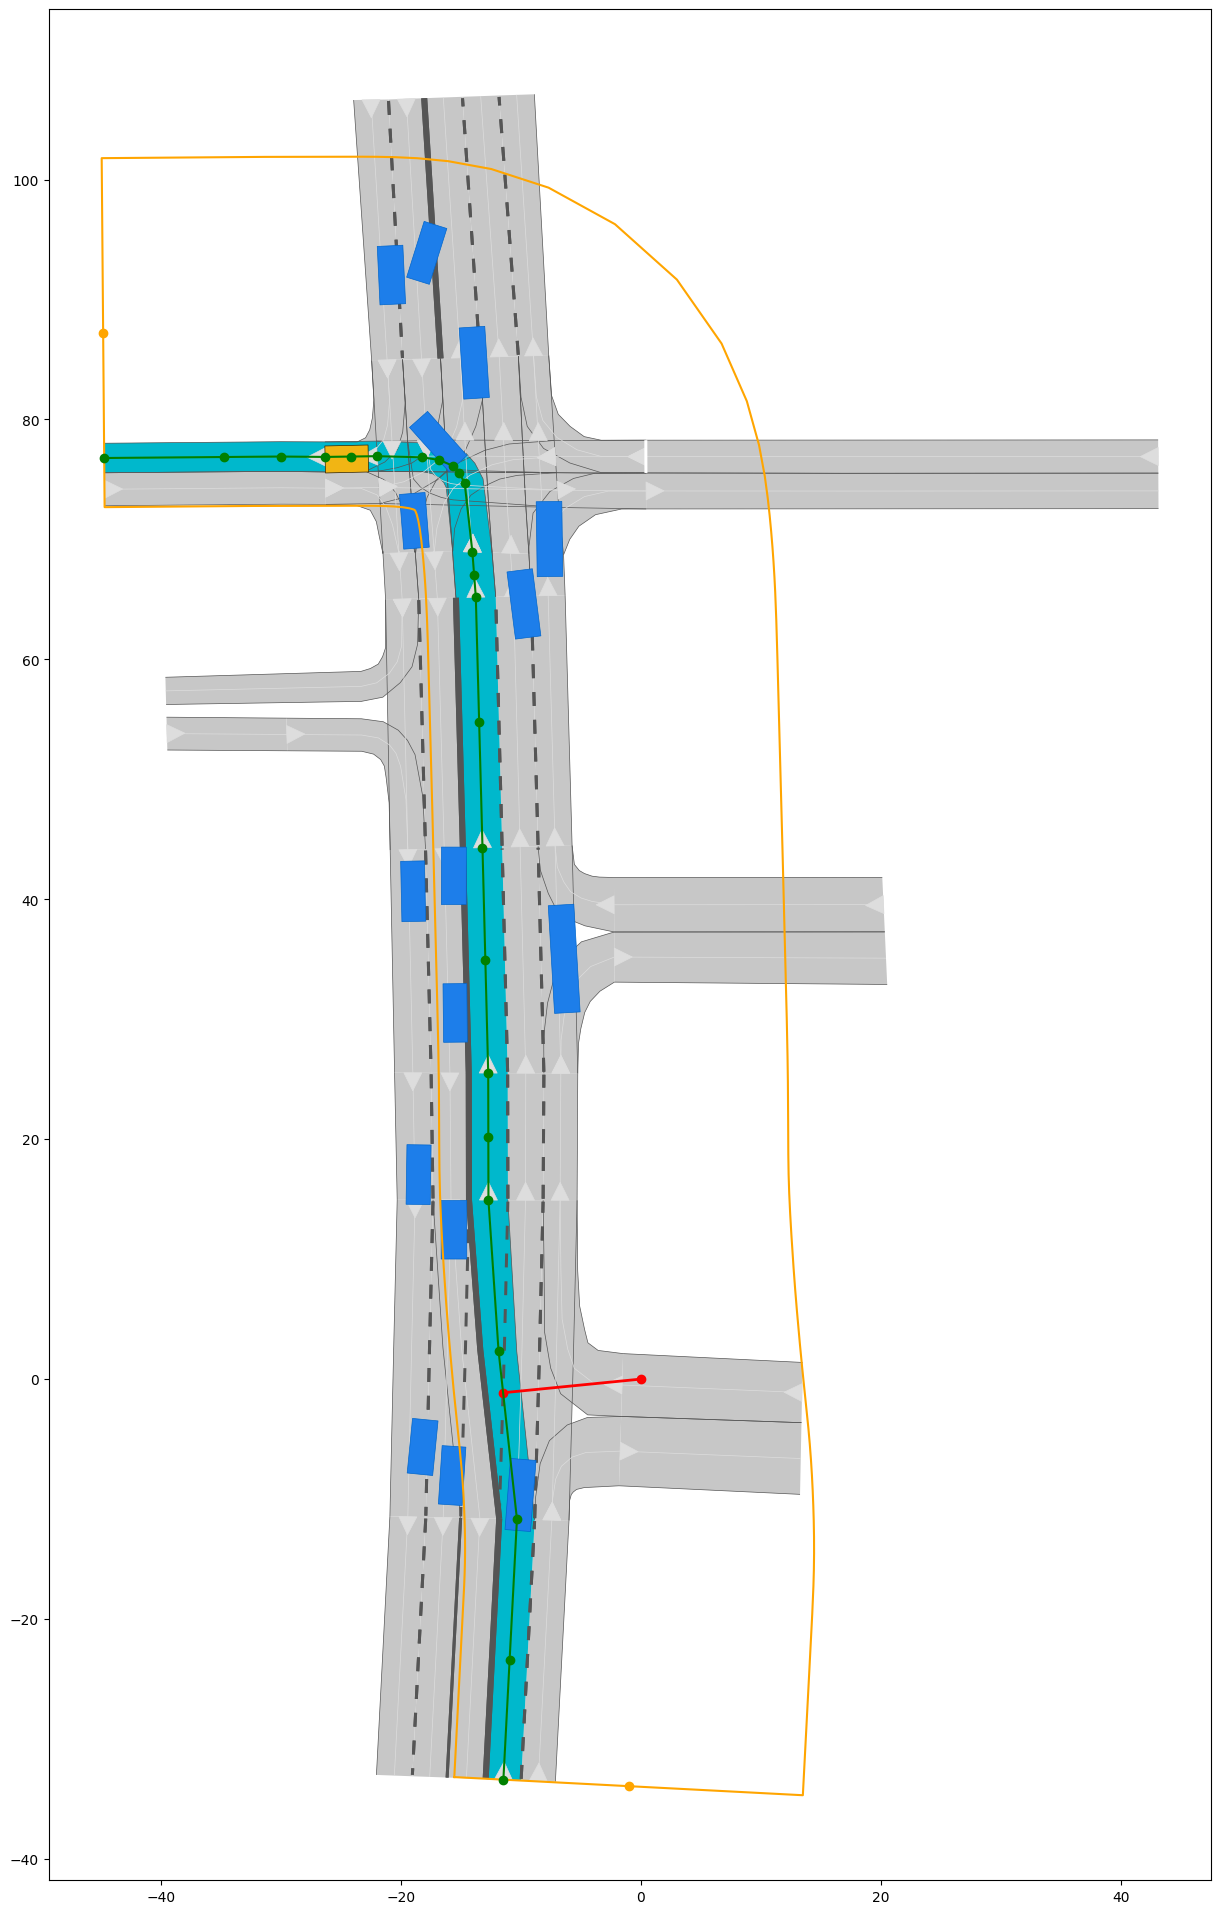

In [5]:
cartesian_position = np.array([0, 0])
project_and_plot(lanelet_ccosy, cartesian_position)

Orginal position: [ -1.03305862 -33.93873331]
Converted curvilinear position: [ 9.99995473e-05 -1.04512630e+01], relative position: LongitudinalRelativePointPosition.InDomain
Backconverted cartesian position: (array([ -1.03305862, -33.93873331]), <LongitudinalRelativePointPosition.InDomain: 0>)
Projected point on the lanelet: [-11.47019038 -33.39542903], relative position: LongitudinalRelativePointPosition.InDomain


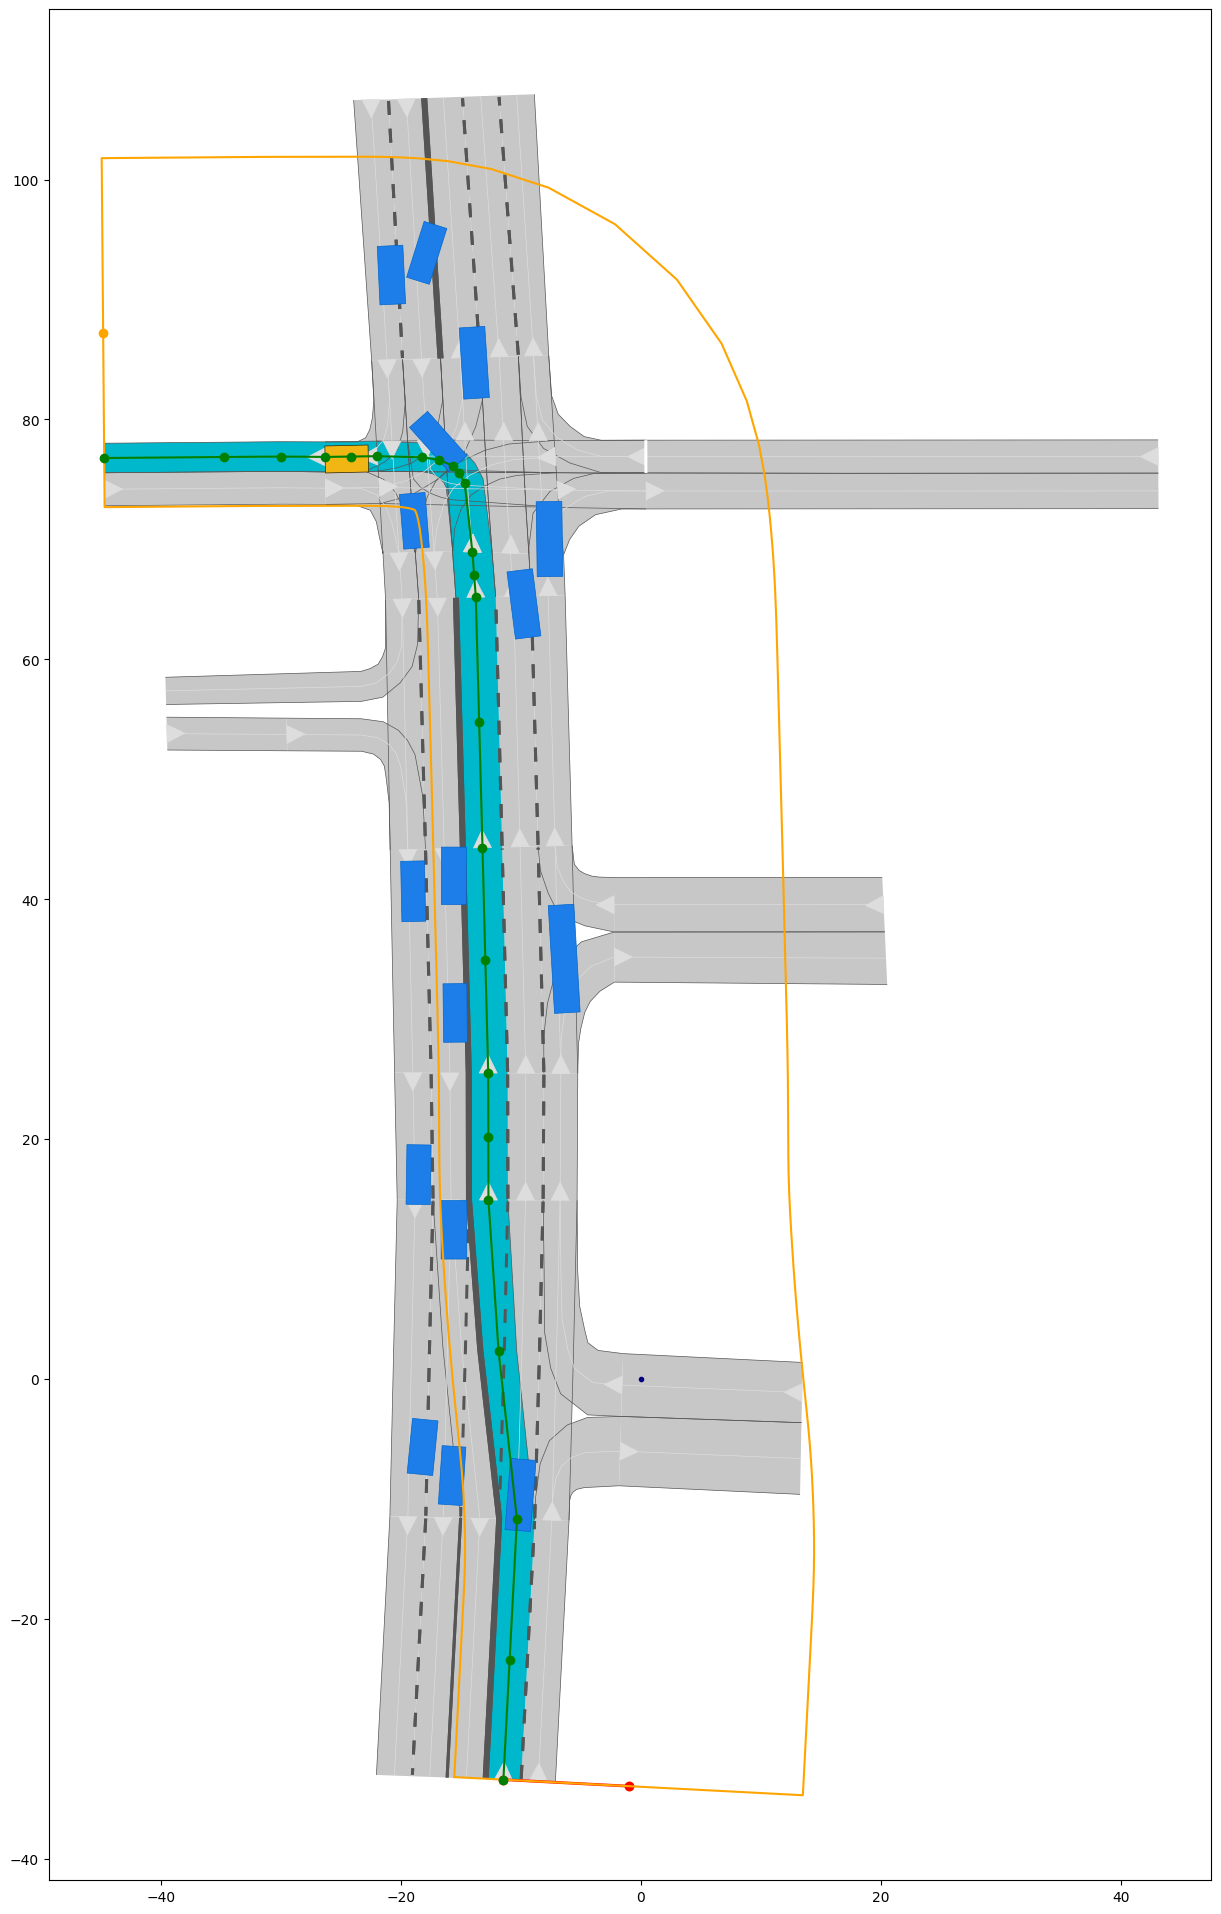

In [6]:
cartesian_position = lanelet_ccosy.bounding_points[0, :]
project_and_plot(lanelet_ccosy, cartesian_position)

Orginal position: [-44.83837745  87.24044252]
Converted curvilinear position: [138.41139661 -10.45126303], relative position: LongitudinalRelativePointPosition.InDomain
Backconverted cartesian position: (array([-44.83837745,  87.24044252]), <LongitudinalRelativePointPosition.InDomain: 0>)
Projected point on the lanelet: [-44.75105035  76.78954434], relative position: LongitudinalRelativePointPosition.InDomain


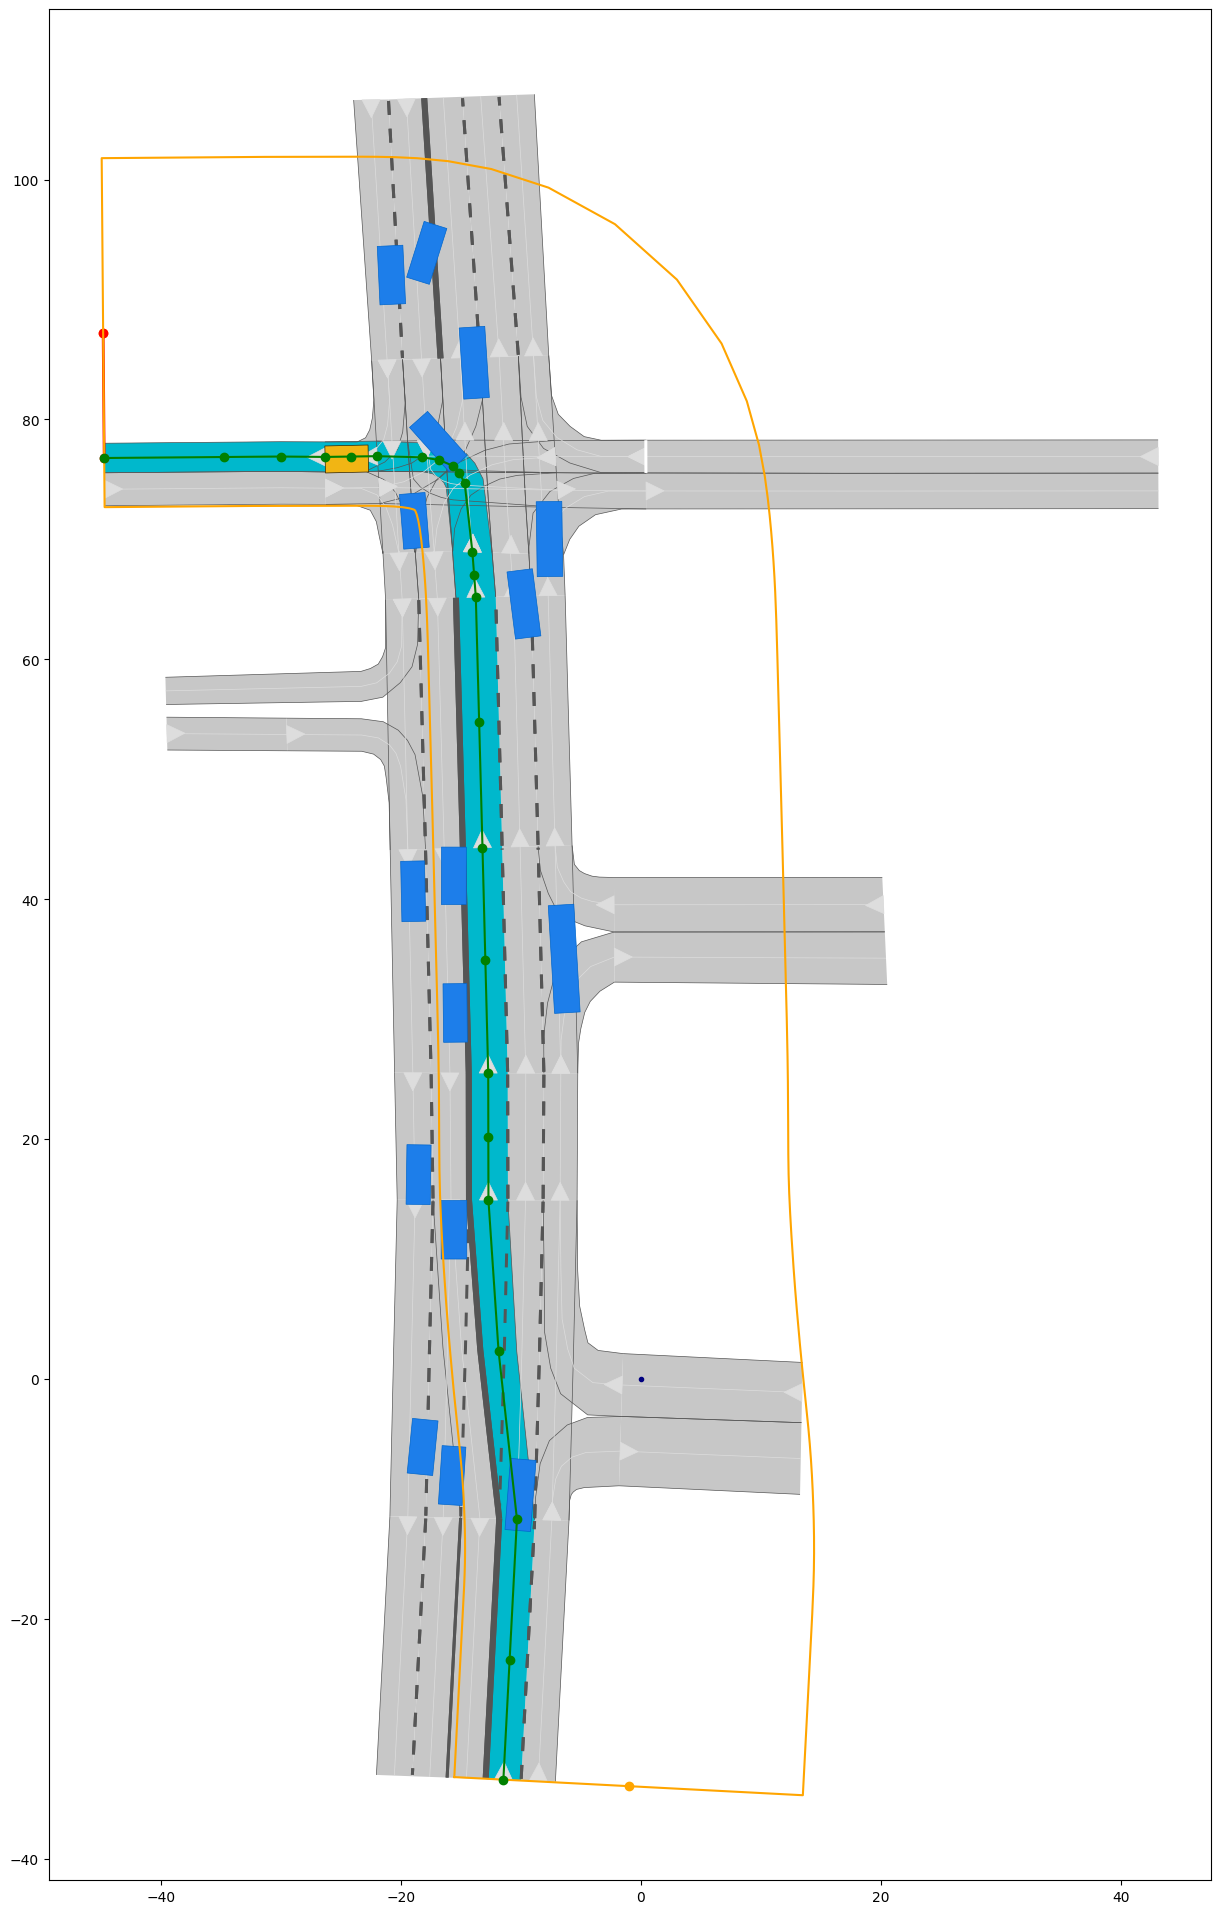

In [7]:
cartesian_position = lanelet_ccosy.bounding_points[1, :]
project_and_plot(lanelet_ccosy, cartesian_position)

### Step 5: Project positions from outside of the projection domain

Now, we can convert coordinates from the Cartesian frame to the lanelet-based curvilinear coordinate system and backwards.


In [8]:
bounding_points_offset = np.array(
            [lanelet_ccosy.convert_to_cartesian_coords(lanelet_ccosy.longitudinal_min, lanelet_ccosy.normal_center-1),
             lanelet_ccosy.convert_to_cartesian_coords(lanelet_ccosy.longitudinal_max, lanelet_ccosy.normal_center-1)])

Orginal position: [ -0.03441073 -33.99071787]
Converted curvilinear position: [ 9.99995473e-05 -1.14512630e+01], relative position: LongitudinalRelativePointPosition.InDomain
Backconverted cartesian position: (array([ -0.03441073, -33.99071787]), <LongitudinalRelativePointPosition.InDomain: 0>)
Projected point on the lanelet: [-11.47019038 -33.39542903], relative position: LongitudinalRelativePointPosition.InDomain


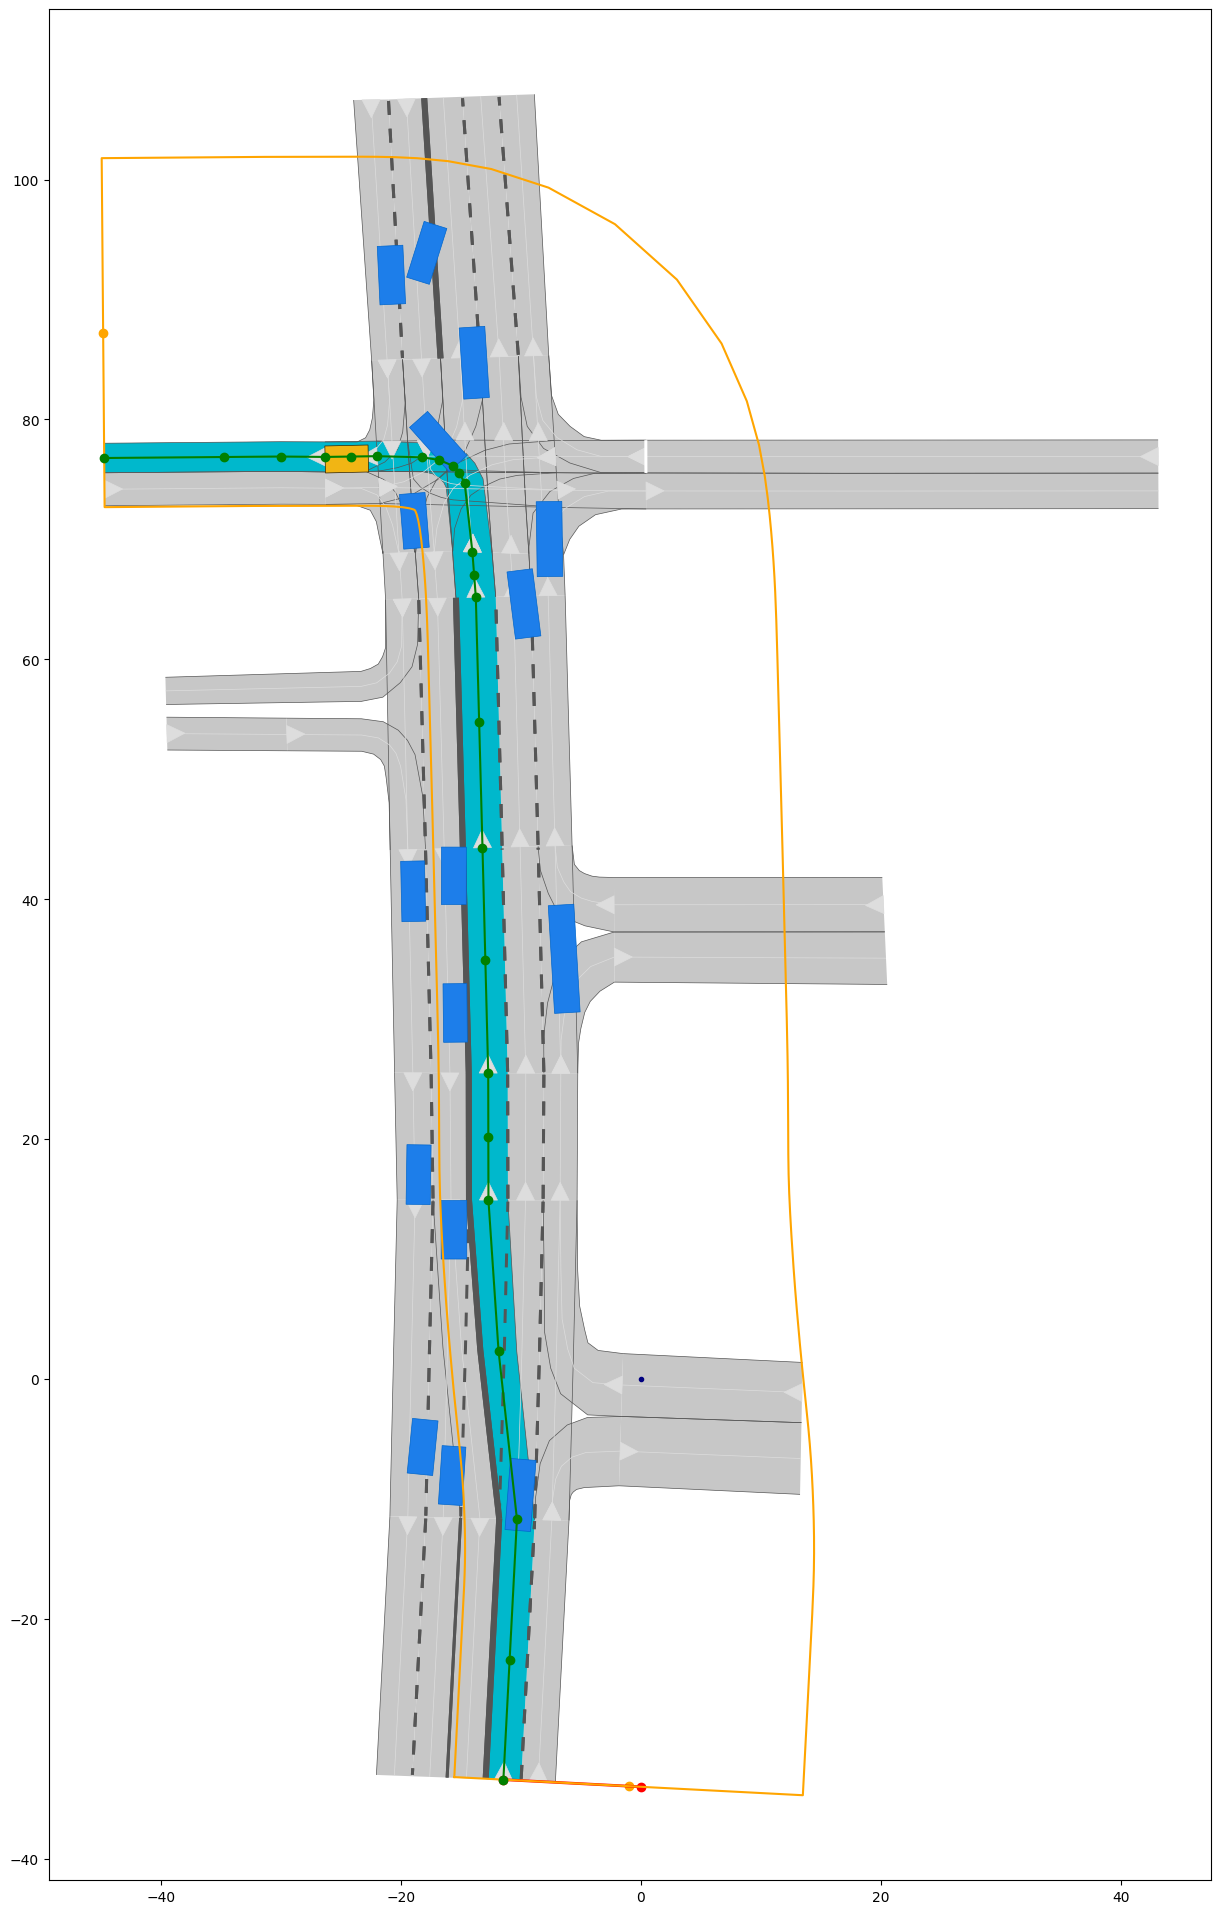

In [9]:
cartesian_position = bounding_points_offset[0, :]
project_and_plot(lanelet_ccosy, cartesian_position)

Orginal position: [-20   0]
Converted curvilinear position: [34.20602312  2.3781746 ], relative position: LongitudinalRelativePointPosition.InDomain
Backconverted cartesian position: (array([-14.02334456,   0.52024428]), <LongitudinalRelativePointPosition.InDomain: 0>)
Projected point on the lanelet: [-11.65538951   0.74047902], relative position: LongitudinalRelativePointPosition.InDomain


/home/vit/miniconda2/envs/driv2/lib/python3.7/site-packages/commonroad_drivability_checker-2020.1-py3.7-linux-x86_64.egg/commonroad_dc/lanelet_ccosy/lanelet_ccosy.py:180: UserWarning: The to-be-projected point is out-of-domain laterally, the projection may be inaccurate
  warnings.warn(f"The to-be-projected point is out-of-domain laterally, "


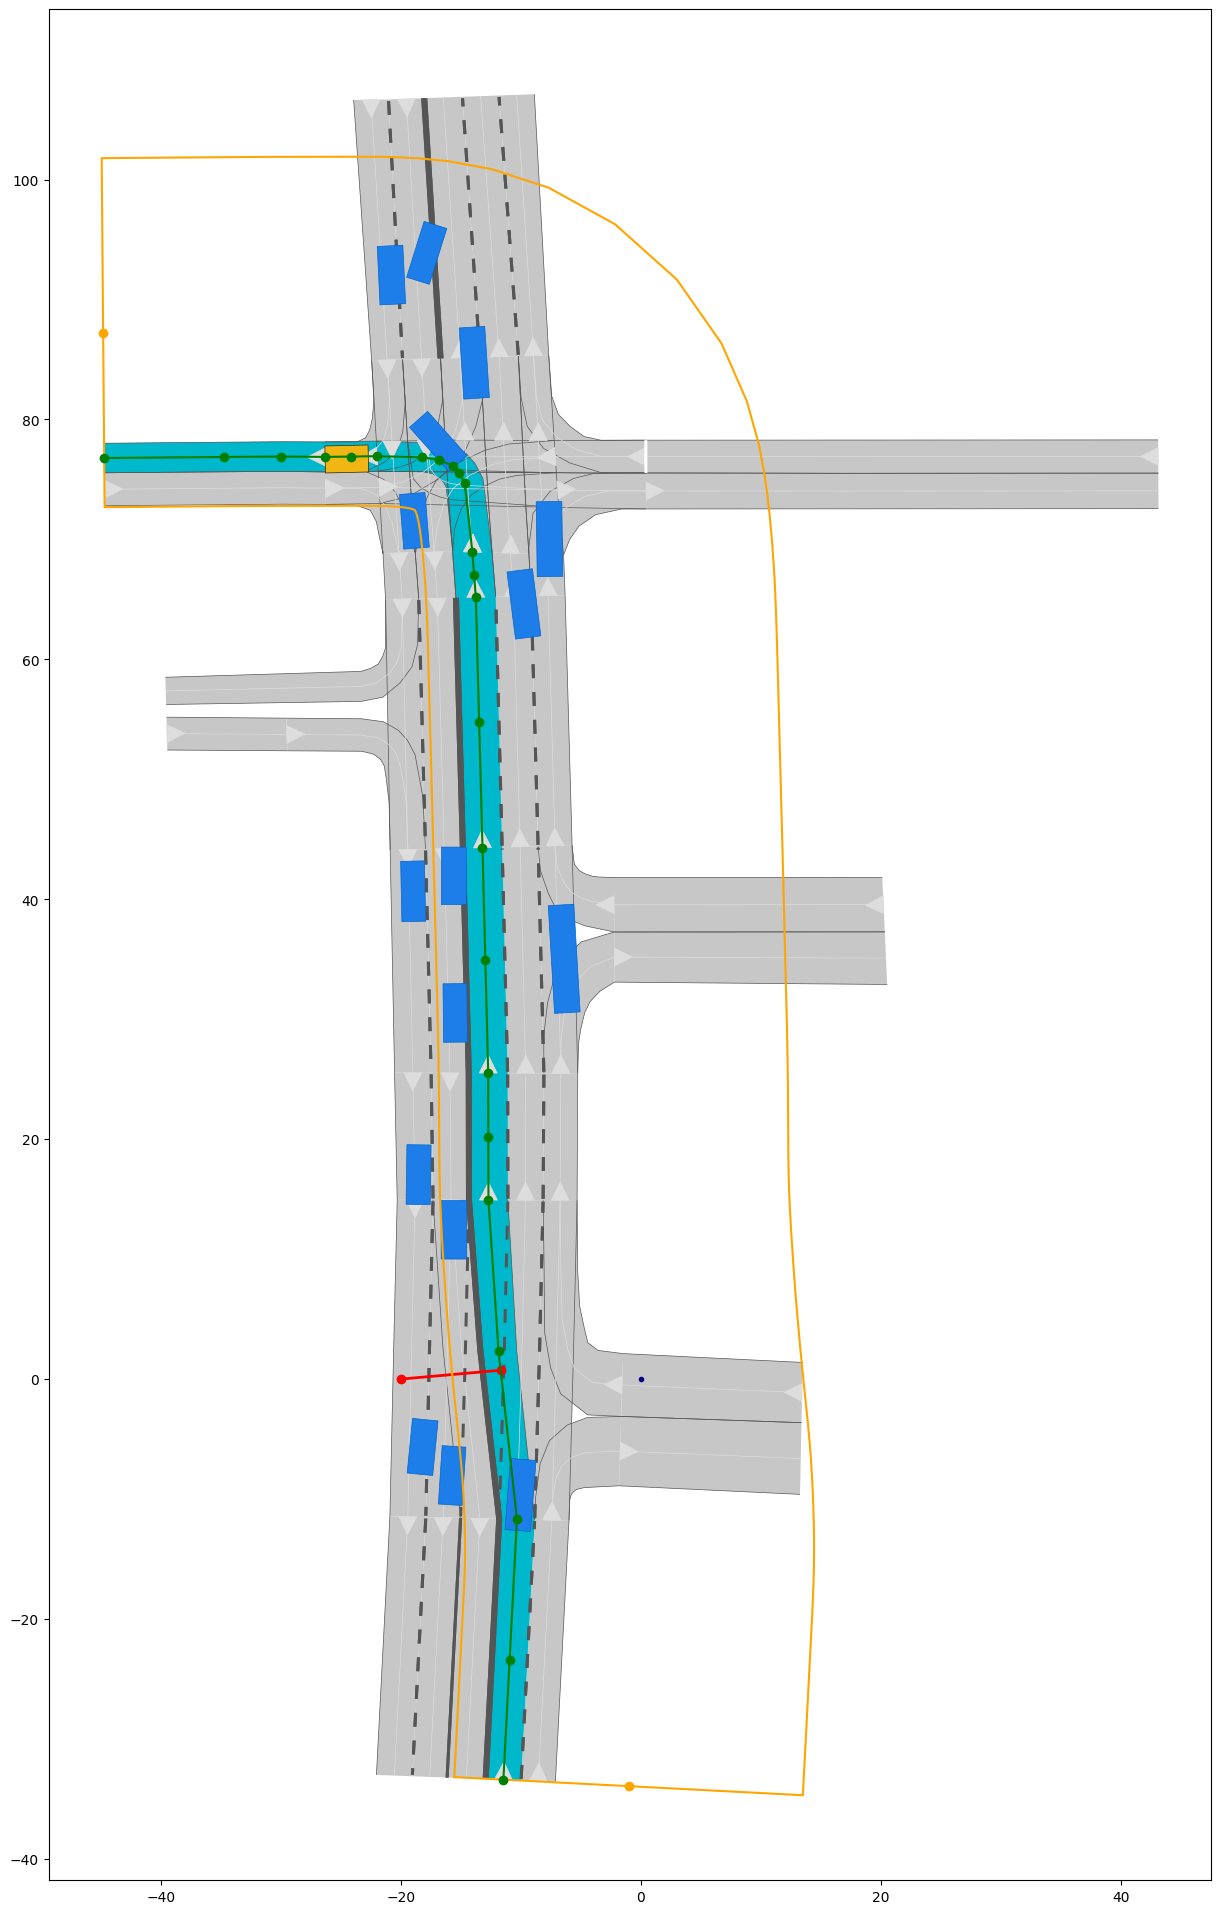

In [10]:

cartesian_position = np.array([-20, 0])
project_and_plot(lanelet_ccosy, cartesian_position)
